In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from collections import OrderedDict

def extract(logfile, var_list, thin=48, pos=3):
    """
    logfile: str
    
    var_list: a list of variable names
    
    thin: should thin more at shorter time step
          48 = one value per day at C48
    
    pos: 3 = the maximum value (the 4-th word in a line)
         6 = the minimum value (the 7-th word in a line)
    """
        
    # Data are hold as ordered dictionary
    # 'plume01' - list
    # 'plume02' - list
    data_dict = OrderedDict()
    for varname in var_list:
        data_dict[varname]=[]
    
    # scan by line
    with open(logfile, 'r') as fi:        
        for ln in fi:
            for varname in var_list:
                # to be safe, match 2 patterns
                if varname in ln and 'max =' in ln:
                    # get the pos+1-th word
                    data_dict[varname].append(ln.split()[pos]) 
                
    # thin the data and convert to numpy array 
    for varname in var_list:
        data_dict[varname] = np.array(data_dict[varname][::thin],
                                      dtype=np.float32)
                    
    # convert the dict from extract() to one-dimenisional DataSet
    ds = pd.DataFrame.from_dict(data_dict).to_xarray().\
         rename(dict(index='time'),inplace=True)
    
    return ds

In [9]:
# test function
maindir = "/Users/desnow/Research/FV3/logfile_FV3/"
var_list = ['plume0{0}'.format(i) for i in range(1,5)]

extract(maindir+'C48L20_std.log',var_list=var_list)

<xarray.Dataset>
Dimensions:  (time: 9)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8
Data variables:
    plume01  (time) float32 1.0 0.884535 0.541212 0.319658 0.223772 0.184812 ...
    plume02  (time) float32 1.0 0.953083 0.627592 0.48241 0.321449 0.234891 ...
    plume03  (time) float32 1.0 0.66268 0.372343 0.251123 0.179862 0.137592 ...
    plume04  (time) float32 1.0 0.774934 0.533533 0.388228 0.263247 0.197932 ...

In [10]:
# Loop over vertical res

def extract_Vs(maindir, var_list, Hres, Vres_list, thin=48, pos=3, suffix='_std.log'):

    ds_Vs_arr = [] # list if timeseries at vertical different resolutions

    for Vres in Vres_list:
        logfile = 'C{0}L{1}'.format(Hres,Vres)+suffix
        print('open:',logfile)
        ds_Vs_arr.append( extract(maindir+logfile, var_list,
                                  thin=thin, pos=pos) )

    ds_Vs = xr.concat(ds_Vs_arr, dim='Vres')
    ds_Vs["Vres"]=np.array(Vres_list)
    return ds_Vs

In [11]:
# Test vertical res function
maindir = "/Users/desnow/Research/FV3/logfile_FV3/"
Vres_list = [20,40,80,160]
Hres = 48
varname_list = ['plume0{0}'.format(i) for i in range(1,5)]

extract_Vs(maindir, var_list, Hres, Vres_list)

open: C48L20_std.log
open: C48L40_std.log
open: C48L80_std.log
open: C48L160_std.log


<xarray.Dataset>
Dimensions:  (Vres: 4, time: 9)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8
  * Vres     (Vres) int64 20 40 80 160
Data variables:
    plume01  (Vres, time) float32 1.0 0.884535 0.541212 0.319658 0.223772 ...
    plume02  (Vres, time) float32 1.0 0.953083 0.627592 0.48241 0.321449 ...
    plume03  (Vres, time) float32 1.0 0.66268 0.372343 0.251123 0.179862 ...
    plume04  (Vres, time) float32 1.0 0.774934 0.533533 0.388228 0.263247 ...

In [18]:
# Loop over horizontal res

def extract_HsVs(maindir, var_list, Hres_list, Vres_list, 
                 thin_base=48, pos=3, suffix='_std.log'):

    ds_HsVs_arr = [] # list of timeseries at different horizontal and vertical resolutions

    for Hres in Hres_list:
        
        # thin more at higher horizontal resolutiom (more time steps)
        ds_HsVs_arr.append( extract_Vs(maindir, var_list, Hres, Vres_list ,
                                       thin=np.int(thin_base*Hres/48)) )

    ds_HsVs = xr.concat(ds_HsVs_arr, dim='Hres')
    ds_HsVs["Hres"]=np.array(Hres_list)
    
    return ds_HsVs

In [24]:
# Extract all results!

maindir = "/Users/desnow/Research/FV3/logfile_FV3/"
Vres_list = [20,40,80,160]
Hres_list = [48,96,192,384]
varname_list = ['plume0{0}'.format(i) for i in range(1,5)]

ds = extract_HsVs(maindir, var_list, Hres_list, Vres_list)
ds

open: C48L20_std.log
open: C48L40_std.log
open: C48L80_std.log
open: C48L160_std.log
open: C96L20_std.log
open: C96L40_std.log
open: C96L80_std.log
open: C96L160_std.log
open: C192L20_std.log
open: C192L40_std.log
open: C192L80_std.log
open: C192L160_std.log
open: C384L20_std.log
open: C384L40_std.log
open: C384L80_std.log
open: C384L160_std.log


<xarray.Dataset>
Dimensions:  (Hres: 4, Vres: 4, time: 9)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8
  * Vres     (Vres) int64 20 40 80 160
  * Hres     (Hres) int64 48 96 192 384
Data variables:
    plume01  (Hres, Vres, time) float32 1.0 0.884535 0.541212 0.319658 ...
    plume02  (Hres, Vres, time) float32 1.0 0.953083 0.627592 0.48241 ...
    plume03  (Hres, Vres, time) float32 1.0 0.66268 0.372343 0.251123 ...
    plume04  (Hres, Vres, time) float32 1.0 0.774934 0.533533 0.388228 ...

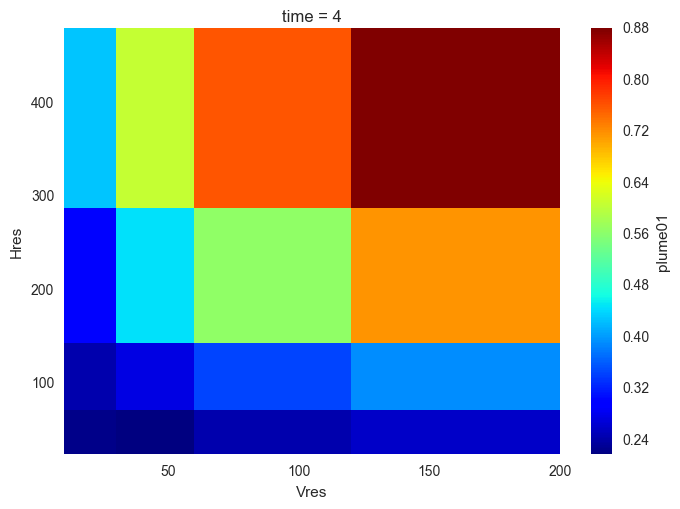

In [33]:
ds['plume01'].sel(time=4).plot(cmap='jet')